In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import glob
import os
import cv2
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

from detectron2.engine import DefaultTrainer

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

/opt/conda/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
def get_ead_dicts(img_dir):    
    images_path = os.path.join(img_dir, '*.jpg')
    images = glob.glob(images_path)
    
    dataset_dicts = []
    
    for idx, image_path in enumerate(images):
        text_path= image_path.replace(".jpg", ".txt")
        
        record = {}

        height, width = cv2.imread(image_path).shape[:2]
        
        record["file_name"] = image_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width        
        
        with open(text_path) as f:
            contents = f.readlines()
        
        objs = []
        for content in contents:
            information = content.split(' ')
            
            obj = {
                "bbox": [(float(information[1]) - float(information[3]) / 2)*width, 
                         (float(information[2]) - float(information[4]) / 2)*height, 
                         (float(information[1]) + float(information[3]) / 2)*width, 
                         (float(information[2]) + float(information[4]) / 2)*height],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(information[0])
            }
            objs.append(obj)
                        
        record["annotations"] = objs
        dataset_dicts.append(record)                        
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog

data_path = r'/home/ws2080/Desktop/codes/models/research/ead/data/'
train_path = r'/home/ws2080/Desktop/data/training/train/'
validation_path = r'/home/ws2080/Desktop/data/training/validation/'

'''
d= 'train'
DatasetCatalog.register("ead_train_1", lambda d=d: get_ead_dicts(train_path))
MetadataCatalog.get("ead_train_1").set(thing_classes=["specularity", "saturation", "artifact", "blur", "contrast", "bubbles", "instrument", "blood"])

'''

d= 'validation'
DatasetCatalog.register("ead_validation_1", lambda d=d: get_ead_dicts(validation_path))
MetadataCatalog.get("ead_validation_1").set(thing_classes=["specularity", "saturation", "artifact", "blur", "contrast", "bubbles", "instrument", "blood"])

Metadata(name='ead_validation_1', thing_classes=['specularity', 'saturation', 'artifact', 'blur', 'contrast', 'bubbles', 'instrument', 'blood'])

In [3]:
model_path = 'output_9'
checkpoints = ['0009999',
               '0019999',
               '0029999',
               '0039999',
               '0049999',
               '0059999',
               '0069999',    
               '0079999',
               '0089999',    
               '0099999', 
               '0109999', 
               '0119999', 
               '0129999',
               '0139999',
               '0149999',
               '0159999',
               '0169999',
               '0179999',
               '0189999',
               '0199999']

In [4]:
APs =[]
AP50s = []
AP75s = []

In [5]:
for checkpoint in checkpoints:
    cfg = get_cfg()

    cfg.merge_from_file(model_path+"/config.yaml")
    model = build_model(cfg)
    DetectionCheckpointer(model).load(model_path+"/model_"+checkpoint+".pth")
    
    evaluator = COCOEvaluator("ead_validation_1", cfg, False, output_dir="./output/")
    val_loader = build_detection_test_loader(cfg, "ead_validation_1")
    a = inference_on_dataset(model, val_loader, evaluator)
    
    APs.append(a.get('bbox')['AP'])
    AP50s.append(a.get('bbox')['AP50'])
    AP75s.append(a.get('bbox')['AP75'])
    

WARNING [02/23 21:58:30 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'ead_validation_1'
[02/23 21:58:30 d2.data.datasets.coco]: Converting dataset annotations in 'ead_validation_1' to COCO format ...)
[02/23 21:58:31 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/23 21:58:32 d2.data.datasets.coco]: Conversion finished, num images: 300, num annotations: 3598
[02/23 21:58:32 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/ead_validation_1_coco_format.json
[02/23 21:58:33 d2.data.build]: Distribution of instances among all 8 categories:
|  category   | #instances   |  category  | #instances   |  category  | #instances   |
|:-----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| specularity | 1399         | saturation | 173          |  artifact  | 969          |
|    blur     | 96           |  contrast  | 224          |  bubbles   | 622          |
| instrument  | 62           |   b

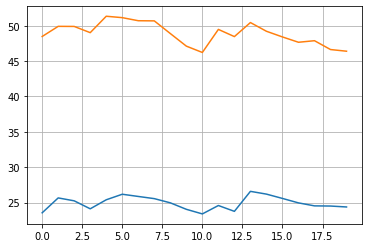

In [6]:
plt.grid(True)
plt.plot(APs)
plt.plot(AP50s)

In [7]:
APs

[23.54148156907953,
 25.64902121611055,
 25.237210792657745,
 24.107917027515178,
 25.38522100081583,
 26.16867267387023,
 25.855799651995337,
 25.54757296485809,
 24.953006336822135,
 24.03716321970156,
 23.38537211482386,
 24.57448334845891,
 23.74874176625008,
 26.57833107486939,
 26.186728668045095,
 25.575208035788343,
 24.94493973887077,
 24.524188859555156,
 24.49907722079604,
 24.367781116372772]

In [8]:
AP50s

[48.48800233215177,
 49.92197565093069,
 49.909262012634265,
 49.03011844763641,
 51.35203105722069,
 51.15315873967413,
 50.7175177552611,
 50.6966238516545,
 48.903469379665275,
 47.123500176273694,
 46.22657767061289,
 49.4909356676074,
 48.47256879917423,
 50.45931459854677,
 49.22621721331643,
 48.424020433251926,
 47.670795976203415,
 47.89109092357235,
 46.641450052802384,
 46.404239544957456]